# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = len(data['income'])

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = (data['income']=='>50K').sum()

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = (data['income']=='<=50K').sum()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (float( n_greater_50k) / (n_records) )*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

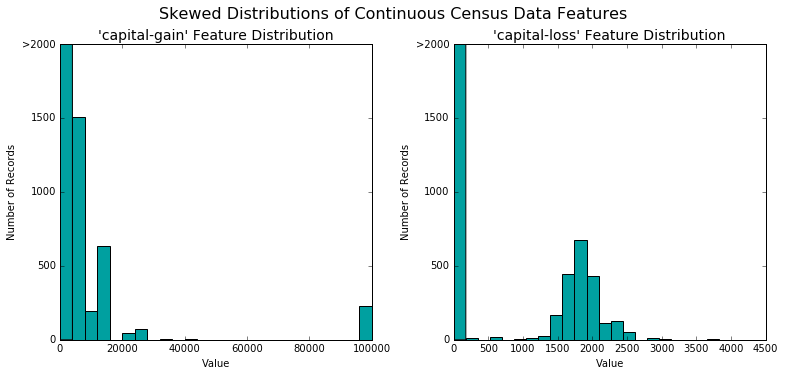

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

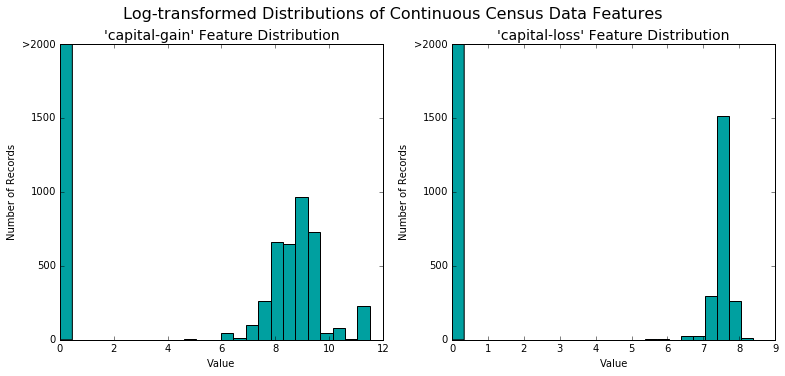

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
income = le.fit_transform(income_raw)

# if needed we can reverse the transform
print le.inverse_transform(income)

['<=50K' '<=50K' '<=50K' ..., '<=50K' '<=50K' '>50K']


In [20]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x=='<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded
display(features.head(n = 1))

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.30137,0.8,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [18]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
# TODO: Calculate accuracy
#Accuracy=(TP+TN)/(TP+TN+FP+FN)
TP = float(n_greater_50k)
FP = float(n_at_most_50k)
TN = 0.0
FN = 0.0
accuracy = (TP+TN)/(TP+TN+FP+FN)

precision = TP/(TP+FP)
recall = TP/(TP+FN)
print precision, recall
# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = (1.+(.5)**2)*((precision*recall)/((((.5)**2)*precision)+recall))

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

0.247843969749 1.0
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **



#### 1 - Decision Trees

#####  real-world application 

- Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.(Reference: https://en.wikipedia.org/wiki/Operations_research)

#####   strengths of the model

- Easy to interpret and explain. They easily handle feature interactions and they’re non-parametric, so there would be no outliers or whether the data is linearly separable. Plus, random forests are good choices for many problems in classification , they’re fast and scalable, and there is no need for tuning many parameters like SVMs.

#####  weaknesses of the model

- One disadvantage is that they don’t support online learning, so you have to rebuild your tree when new examples come on. Another disadvantage is that they easily overfit, but that’s where ensemble methods like random forests (or boosted trees) come in.

#####  being a good candidate for the problem

- In addition to simplicity and ease of implementation, we can use it as a base clasifier for ensemble methods like random forests. 


#### 2 - Logistic Regression

#####  real-world application 

- Logistic regression, also called logit regression or logit modeling, is a statistical technique allowing researchers to create predictive models. The technique is most useful for understanding the influence of several independent variables on a single dichotomous outcome variable.Using Binary Logistic Regression to Investigate High Employee Turnover is a real life example of this model:
http://blog.minitab.com/blog/real-world-quality-improvement/using-binary-logistic-regression-to-investigate-high-employee-turnover

#####   strengths of the model

-  Lots of ways to regularize the model, and not sensitive to the features being correlated, unlike Naive Bayes. 
- It also has a nice probabilistic interpretation, unlike decision trees or SVMs, and can easily update the model to take in new data 
- Logistic regression works well for predicting categorical outcomes like admission or rejection at a particular college. It can also predict multinomial outcomes, like admission, rejection or wait list.
- it is more robust: the independent variables don’t have to be normally distributed, or have equal variance in each group
- It does not assume a linear relationship between the IV and DV
- It may handle nonlinear effects
- You can add explicit interaction and power terms
- The DV need not be normally distributed.
- There is no homogeneity of variance assumption.
- Normally distributed error terms are not assumed.
- It does not require that the independents be interval or unbounded.

#####  weaknesses of the model

- Logistic regression attempts to predict outcomes based on a set of independent variables, but if researchers include the wrong independent variables, the model will have little to no predictive value.
- Logistic regression requires that each data point be independent of all other data points. If observations are related to one another, then the model will tend to overweight the significance of those observations. This is a major disadvantage, because a lot of scientific and social-scientific research relies on research techniques involving multiple observations of the same individuals. 
- Logit models are vulnerable to overconfidence. That is, the models can appear to have more predictive power than they actually do as a result of sampling bias.

#####  being a good candidate for the problem

- With this model we would not be worry if there is any correclations between features we want to use in our model. We would also not be limited to linear relation between IV and DV.    


#### 3 - Ensemble Methods

#####  real-world application 

- Classifier ensembles are aggregations of several classifiers whose individual predictions are combined in some manner (e.g., averaging or voting) to form a final prediction. Because they use all the available classifier information, ensembles generally provide better and/or more robust solutions in most applications. This technique became popular after the Netflix Challenge where the winning teams used ensembles of a lot of models to win the competition. (Reference: http://www.netflixprize.com/community/topic_1537.html)

#####   strengths of the model

- The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.
- Two families of ensemble methods are usually distinguished:
    In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.
Examples: Bagging methods, Forests of randomized trees, ...

- By contrast, in boosting methods, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.
Examples: AdaBoost, Gradient Tree Boosting, ...

- implementation simplicity It can work with any learning algorithm for solving class problems

#####  weaknesses of the model

-  If you use the wrong ensemble method for your setting, you are not going to do better. 
-  If you need to work in a probabilistic setting, ensemble methods may not work either. It is known that Boosting (in its most popular forms like AdaBoost) delivers poor probability estimates. That is, if you would like to have a model that allows you to reason about your data, not only classification, you might be better off with a graphical model.

#####  being a good candidate for the problem

- It can aggregate several classifiers to improve generalizability / robustness over a single estimator. We can try different ensemble methods and choose the one with best performance through using different parameters and also different sets of features. 


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score 
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=1.0)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=1.0)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

# I made Model Evalution for all suggested models and compared their results with my chosen three models at the end.
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

GaussianNB trained on 361 samples.
0 361
GaussianNB trained on 3617 samples.
1 3617
GaussianNB trained on 36177 samples.
2 36177
DecisionTreeClassifier trained on 361 samples.
0 361
DecisionTreeClassifier trained on 3617 samples.
1 3617
DecisionTreeClassifier trained on 36177 samples.
2 36177
KNeighborsClassifier trained on 361 samples.
0 361
KNeighborsClassifier trained on 3617 samples.
1 3617
KNeighborsClassifier trained on 36177 samples.
2 36177
GaussianNB


,1%,10%,100%
acc_test,0.351797,0.367385,0.608292
acc_train,0.400000,0.386667,0.593333
f_test,0.414227,0.428486,0.536923
f_train,0.444444,0.435583,0.519685
pred_time,0.038000,0.041000,0.029000
train_time,0.003000,0.016000,0.128000


KNeighborsClassifier


,1%,10%,100%
acc_test,0.804865,0.818242,0.820122
acc_train,0.866667,0.860000,0.873333
f_test,0.543338,0.588176,0.608988
f_train,0.677419,0.676923,0.712121
pred_time,0.661000,4.436000,29.012000
train_time,0.002000,0.025000,1.118000


DecisionTreeClassifier


,1%,10%,100%
acc_test,0.755445,0.802764,0.818684
acc_train,1.000000,0.996667,0.970000
f_test,0.527754,0.603908,0.623508
f_train,1.000000,0.993007,0.934307
pred_time,0.009000,0.008000,0.009000
train_time,0.003000,0.039000,0.506000


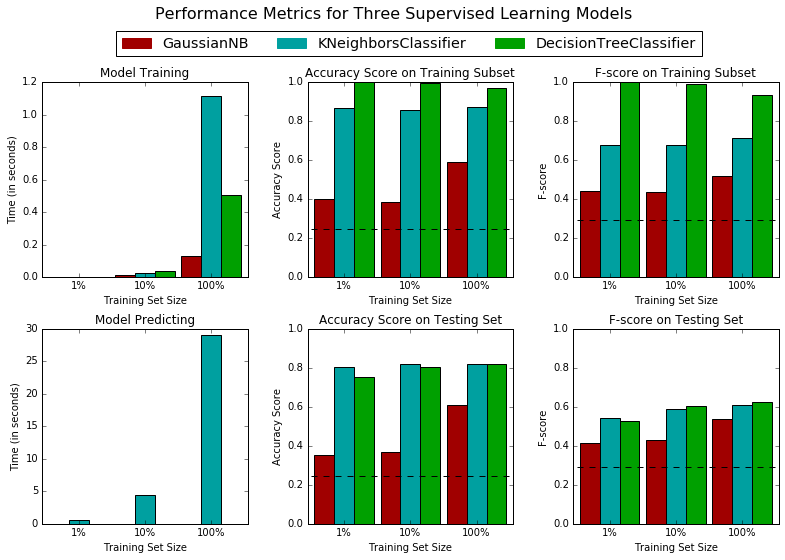

In [21]:
# TODO: Import the three supervised learning models from sklearn 
#•Gaussian Naive Bayes (GaussianNB)
#•Decision Trees
#•K-Nearest Neighbors (KNeighbors)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = KNeighborsClassifier()


# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0]/100
samples_10 = X_train.shape[0]/10
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        print i, samples
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))        
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


LinearSVC trained on 361 samples.
0 361
LinearSVC trained on 3617 samples.
1 3617
LinearSVC trained on 36177 samples.
2 36177
SGDClassifier trained on 361 samples.
0 361
SGDClassifier trained on 3617 samples.
1 3617
SGDClassifier trained on 36177 samples.
2 36177
LogisticRegressionCV trained on 361 samples.
0 361
LogisticRegressionCV trained on 3617 samples.
1 3617
LogisticRegressionCV trained on 36177 samples.
2 36177
LinearSVC


,1%,10%,100%
acc_test,0.802432,0.843339,0.850746
acc_train,0.873333,0.846667,0.850000
f_test,0.561472,0.640811,0.663677
f_train,0.693548,0.616667,0.628099
pred_time,0.009000,0.008000,0.018000
train_time,0.005000,0.057000,0.800000


SGDClassifier


,1%,10%,100%
acc_test,0.806191,0.812383,0.840243
acc_train,0.843333,0.796667,0.836667
f_test,0.498713,0.490237,0.666974
f_train,0.576577,0.419048,0.625954
pred_time,0.006000,0.009000,0.008000
train_time,0.002000,0.014000,0.146000


LogisticRegressionCV


,1%,10%,100%
acc_test,0.817137,0.844997,0.848977
acc_train,0.840000,0.853333,0.853333
f_test,0.534871,0.648269,0.663381
f_train,0.571429,0.633333,0.639344
pred_time,0.006000,0.006000,0.008000
train_time,0.232000,0.732000,12.850000


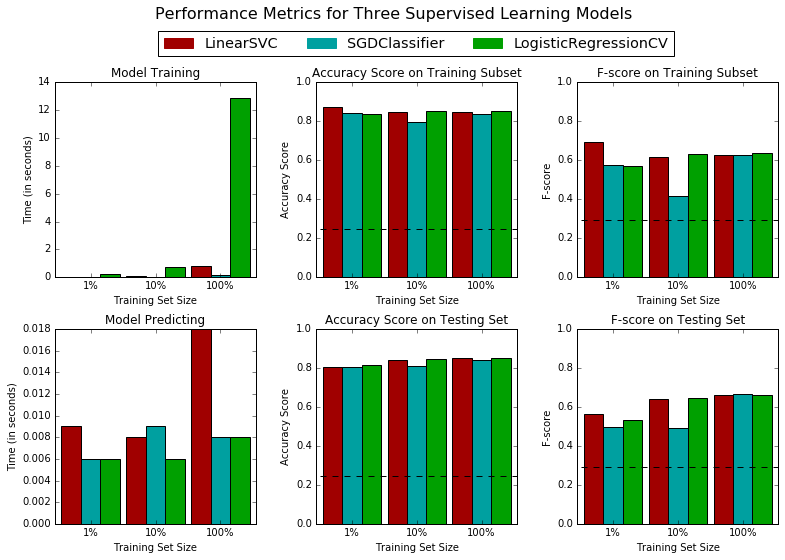

In [22]:
# TODO: Import the three supervised learning models from sklearn  •Gaussian Naive Bayes (GaussianNB)
#•Decision Trees
#•K-Nearest Neighbors (KNeighbors)
#•Stochastic Gradient Descent Classifier (SGDC)
#•Support Vector Machines (SVM)
#•Logistic Regression

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV
# TODO: Initialize the three models
clf_A = LinearSVC(random_state=42)
clf_B = SGDClassifier(random_state=42)
clf_C = LogisticRegressionCV(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0]/100
samples_10 = X_train.shape[0]/10
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        print i, samples
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))          
        
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

RandomForestClassifier trained on 361 samples.
0 361
RandomForestClassifier trained on 3617 samples.
1 3617
RandomForestClassifier trained on 36177 samples.
2 36177
AdaBoostClassifier trained on 361 samples.
0 361
AdaBoostClassifier trained on 3617 samples.
1 3617
AdaBoostClassifier trained on 36177 samples.
2 36177
LogisticRegressionCV trained on 361 samples.
0 361
LogisticRegressionCV trained on 3617 samples.
1 3617
LogisticRegressionCV trained on 36177 samples.
2 36177
LogisticRegressionCV


,1%,10%,100%
acc_test,0.817137,0.844997,0.849088
acc_train,0.840000,0.853333,0.853333
f_test,0.534871,0.648445,0.663710
f_train,0.571429,0.633333,0.639344
pred_time,0.006000,0.006000,0.006000
train_time,0.237000,0.742000,11.767000


AdaBoostClassifier


,1%,10%,100%
acc_test,0.820785,0.849862,0.857601
acc_train,0.893333,0.840000,0.850000
f_test,0.614873,0.665352,0.673924
f_train,0.757576,0.606557,0.621849
pred_time,0.142000,0.138000,0.133000
train_time,0.115000,0.305000,2.514000


RandomForestClassifier


,1%,10%,100%
acc_test,0.808624,0.833057,0.843339
acc_train,0.980000,0.993333,0.973333
f_test,0.565403,0.622122,0.656318
f_train,0.956522,0.985915,0.942029
pred_time,0.056000,0.036000,0.043000
train_time,0.052000,0.113000,0.682000


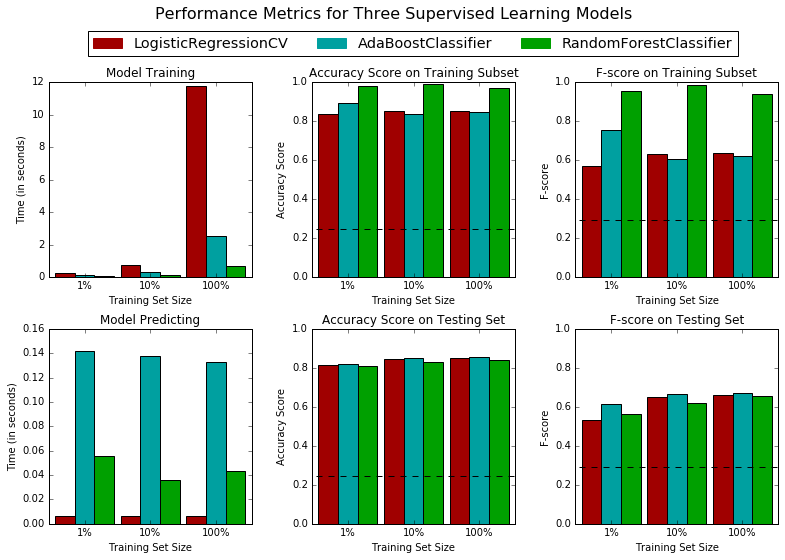

In [23]:
# TODO: Import the three supervised learning models from sklearn  Bagging, ,
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
# TODO: Initialize the three models
clf_A = RandomForestClassifier(random_state=42)
clf_B = AdaBoostClassifier(random_state=42)
clf_C = LogisticRegressionCV(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0]/100
samples_10 = X_train.shape[0]/10
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        print i, samples
        
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))          
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

GradientBoostingClassifier trained on 361 samples.
0 361
GradientBoostingClassifier trained on 3617 samples.
1 3617
GradientBoostingClassifier trained on 36177 samples.
2 36177
AdaBoostClassifier trained on 361 samples.
0 361
AdaBoostClassifier trained on 3617 samples.
1 3617
AdaBoostClassifier trained on 36177 samples.
2 36177
BaggingClassifier trained on 361 samples.
0 361
BaggingClassifier trained on 3617 samples.
1 3617
BaggingClassifier trained on 36177 samples.
2 36177
AdaBoostClassifier


,1%,10%,100%
acc_test,0.820785,0.849862,0.857601
acc_train,0.893333,0.840000,0.850000
f_test,0.614873,0.665352,0.673924
f_train,0.757576,0.606557,0.621849
pred_time,0.135000,0.143000,0.143000
train_time,0.145000,0.308000,2.538000


BaggingClassifier


,1%,10%,100%
acc_test,0.809287,0.835047,0.843449
acc_train,0.983333,0.993333,0.973333
f_test,0.584237,0.626813,0.658960
f_train,0.964029,0.985915,0.942857
pred_time,0.107000,0.089000,0.100000
train_time,0.036000,0.242000,3.512000


GradientBoostingClassifier


,1%,10%,100%
acc_test,0.831399,0.855943,0.863018
acc_train,0.940000,0.883333,0.856667
f_test,0.614412,0.667856,0.683686
f_train,0.857143,0.700855,0.632479
pred_time,0.030000,0.026000,0.030000
train_time,0.118000,1.002000,12.240000


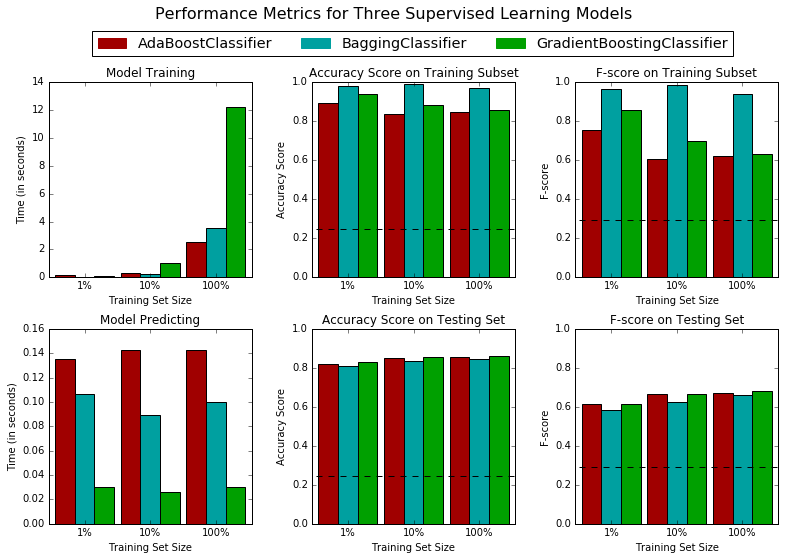

In [24]:
# TODO: Import the three supervised learning models from sklearn  Bagging, ,
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
# TODO: Initialize the three models
clf_A = GradientBoostingClassifier(random_state=42)
clf_B = AdaBoostClassifier(random_state=42)
clf_C = BaggingClassifier(random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0]/100
samples_10 = X_train.shape[0]/10
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
        print i, samples
        
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))          

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [25]:
# Load the Evaluated Models results
results = pd.read_csv("Models.csv")

# Display the Improving results
display(results.head(n=12))

,Classifier (100% data),Model Training time,Model Predicting time,Accuracy Score Testing,F-Score Testing
0,Gaussian Naive Bayes (GaussianNB),1.0,1.000,0.60,0.57
1,Decision Trees,0.5,0.010,0.80,0.62
2,K-Nearest Neighbors (KNeighbors),11.0,28.000,0.80,0.60
3,Stochastic Gradient Descent Classifier (SGDC),0.1,0.005,0.80,0.60
4,Support Vector Machines (SVM),100.0,20.000,0.80,0.58
5,Logistic Regression,11.0,0.005,0.82,0.61
6,Ensemble Methods (Bagging),3.0,0.080,0.86,0.68
7,Ensemble Methods (AdaBoost),2.5,0.130,0.82,0.66
8,Ensemble Methods (Random Forest),1.0,0.040,0.82,0.65
9,Ensemble Methods (Gradient Boosting),11.8,0.025,0.85,0.65


# Model Comparison

As we can see from above table each of the models can be compared with others based on its speed and TESTING accuracy/F-scores. The significant differences are:

- Gaussian Naive Bayes (GaussianNB)takes moderate trining and prediction time but has low Accuracy and F-Score values. So it would not be a good candidate.
- Decision Trees has low trining and prediction time but has high Accuracy and F-Score values. That makes it a good candidate for my model selection.
- K-Nearest Neighbors (KNeighbors)has very long training time and longer prediction time due to the need for recalculating the process for each node. The Accuracy and F-Score values also are lower tan decision tree. SO it is not a good model for our data. 
- Stochastic Gradient Descent Classifier (SGDC)takes much shorter trining and prediction time but has low Accuracy and F-Score values. So it would not be a good candidate. 
- Support Vector Machines (SVM)has longest trining and prediction time with  lowest Accuracy and F-Score values. So it would not be a good candidate at all. 
- Logistic Regression takes very long training time but very short prediction time. With high Accuracy and F-Score values, it is a good candidate for our analysis.
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)have moderate training time and short prediction time. Their Accuracy and F-Score values are high and can be good candidate for the analysis.


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

Among the three selected models Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)have moderate training time and short prediction time. Their Testing Accuracy and Testing F-Score values are high and can be good candidate for the analysis.

Among the Ensemble Methods the Bagging is the most appropriate for the task of identifying individuals that make more than $50,000 because they have highest Accuracy Score and F-Score values for test sets at any percenages of datasets. (Average .86 and .68 respectively) 

The training and predicting times are also much lower than ther methods.(Average 3 and 0.08 seconds respectively)





### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 


### Bootstrap Aggregation (Bagging)

Bootstrap Aggregation (or Bagging for short), is a simple and very powerful ensemble method.

An ensemble method is a technique that combines the predictions from multiple machine learning algorithms together to make more accurate predictions than any individual model to predict the ncome level of being below or above 50k.

Decision trees are sensitive to the specific data on which they are trained. If the training data is changed (e.g. a tree is trained on a subset of the training data) the resulting decision tree can be quite different and in turn the predictions can be quite different.

Bootstrap Aggregation uses several decision trees running on different sets of featurs and then gets the results of all of them. In our case if for example the majority of the results pointed to income higher than 50k, the final result would be above 50k income.

Given a new dataset, calculate the average prediction from each model.
For example, if we had 5 bagged decision trees that made the following class predictions for a in input sample: blue, blue, red, blue and red, we would take the most frequent class and predict blue.



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [28]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.ensemble import BaggingClassifier
# TODO: Initialize the classifier
# class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, 
# max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, 
# oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0

start = time() # Get start time
clf = BaggingClassifier(n_estimators=10, max_samples=1.0, random_state=42)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators' : [5,10,15], 'max_samples' : [.01,0.1,1.0 ], 'n_jobs' : [-1,1]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer )

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print best_clf


end = time() # Get end time
# Calculate the total prediction time
results = end - start
print "Total Process time: ", results

Unoptimized model
------
Accuracy score on testing data: 0.8434
F-score on testing data: 0.6845

Optimized Model
------
Final accuracy score on the testing data: 0.8532
Final F-score on the testing data: 0.7070
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=0.1,
         n_estimators=15, n_jobs=-1, oob_score=False, random_state=42,
         verbose=0, warm_start=False)
Total Process time:  116.513999939


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |      0.8434       |      0.8532     |
| F-score        |      0.2917         |      0.6845       |      0.7070     |


**Answer: **

For optimization of my model,I chose decision tree as the base estimator and the rest of the parameter with their default values exept following parameters:
- 'n_estimators', The number of base estimators in the ensemble: [5,10,15], 
- 'max_samples', The number of samples to draw from X to train each base estimator. : [.01,0.1,1.0 ]
- 'n_jobs' , The number of jobs to run in parallel for both fit and predict.: [-1,1]
My optimized model's accuracy and F-score on the testing data are 0.8532 and 0.7070 respectively that are slightly higher than the unoptimized model with the values of  0.8434 and 0.6845. Bothe result are three to four times better than the the naive predictor benchmarks I found earlier in Question 1 with ethe values 0.2478 and 0.2917 respectively.

But it took about 120 seconds to be completed which is a long time. 

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**


The following five features I believe to be most important for prediction, with highest order being 1 with the reason for each one in front of it:


1- occupation: because the income has direct relation with the occupation and it is a very important feature that determines the level of income.  

2- education-num: The level of education also has direct relation to level of income. 

3- age: Higher age normally might be an indication of level of job experience and then the level of income.

4- capital-gain: The higher the capital gain, the higher the chance of high income.

5- capital-loss: This has reverse relation with income level or willing for donation.









### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

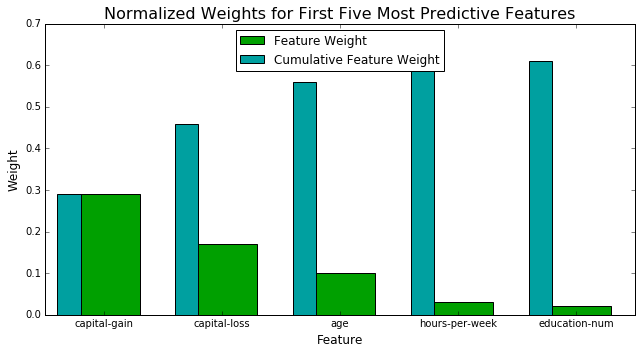

Total Process time:  5.48500013351


In [27]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier
start = time() # Get start time
# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier(n_estimators=100)

# TODO: Extract the feature importances
importances = model.fit(X_train, y_train).feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)


end = time() # Get end time
# Calculate the total prediction time
results = end - start
print "Total Process time: ", results

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

I ran the visualization for Adaboost clasifiers and below is my observations for :

I had four out of five featurs same as the result of visualization and described them on the answer of question 6. 
There are two differences between my prediction and the result of the observation:

1- 'hours-per-week'was not among my prediction. It seems there is a direct relation between hours work per week and the salary level, which sounds reasonable especially if we think about it as an indication of people with permanent jobs or longer working hours that increases their income. It is what I was thinking about 'occupation' feature nut it seems 'hours-per-week' is more relative to that concept.

2- the order of importance is slightly different between the visualization and prediction reults. Based on visulization the order of importance with one to be the most important is:1- capital-gain, 2-capital-loss, 3-age, 4-hours-per-week, 5- education-num. While my prediction ranked them as follows:
    
    1- occupation: because the income has direct relation with the occupation and it is a very important feature that determines the level of income. 
    2- education-num: The level of education also has direct relation to level of income. 
    3- age: Higher age normally might be an indication of level of job experience and then the level of income.
    4- capital-gain: The higher the capital gain, the higher the chance of high income.
    5- capital-loss: This has reverse relation with income level or willing for donation.


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [17]:
# Import functionality for cloning a model
from sklearn.base import clone
start = time() # Get start time
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))


end = time() # Get end time
# Calculate the total prediction time
results = end - start
print "Total Process time: ", results

Final Model trained on full data
------
Accuracy on testing data: 0.8532
F-score on testing data: 0.7070

Final Model trained on reduced data
------
Accuracy on testing data: 0.8231
F-score on testing data: 0.6417
Total Process time:  2.87299990654


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**


|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |   full data   |   Reduced Data  |
| :------------: | :-----------------: | :---------------: | :-------------: |:------------: | :-------------: | 
| Accuracy Score |      0.2478         |      0.8434       |      0.8532     |    0.8532     |      0.8231     |
| F-score        |      0.2917         |      0.6845       |      0.7070     |    0.7070     |      0.6417     |


Although the Accuracy and F-score values reduced 3.5 and 8.5 percent respectively on the reduced data compared to full data, the training time was much faster than full data. For large value of data sets, it makes a significant difference and I would prefer the reduced data to the full data for the analysis.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.